In [1]:
from known_boundary.GP import optimise,optimise_warp
from known_boundary.utlis import Trans_function, get_initial_points,transform
from known_boundary.acquisition_function import EI_acquisition_opt,MES_acquisition_opt,Warped_TEI2_acquisition_opt,LCB_acquisition_opt,ERM_acquisition_opt,Warped_EI_acquisition_opt

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import torch
import botorch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell
from botorch.utils.transforms import unnormalize,normalize

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [17]:
fun = Ackley(dim=7,negate=False)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
 
n_init = 4*dim
iter_num = 60 #10*dim
N = 20

fstar =  0.
fun = Trans_function(fun,fstar,min=True)

# GP+EI

In [12]:
BO_EI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            # print('lengthscale is: ',np.sqrt(res[0])) 
            # print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record)
            
    best_record = np.array(best_record)+fstar 
    BO_EI.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [7]:
np.savetxt('training_check/Beale2D_BO_EI', BO_EI, delimiter=',')

# GP+TEI

In [9]:
BO_TEI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)
    
    fstar0 = 0.


    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            fstar_standard = (fstar0 - Y_BO.mean()) / Y_BO.std()
            fstar_standard = fstar_standard.item()
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            # print('lengthscale is: ',np.sqrt(res[0])) 
            # print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal,f_star=fstar_standard)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record)
            
    best_record = np.array(best_record)+fstar 
    BO_TEI.append(best_record)

0
1
2
3
4
5
6
7
8
9


# GP+LCB

In [7]:
BO_LCB = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            beta = np.sqrt(np.log(train_Y.shape[0]))
            standard_next_X,_ = LCB_acquisition_opt(m,bounds=standard_bounds,beta=beta)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record)
            
    best_record = np.array(best_record)+fstar 
    BO_LCB.append(best_record)

0
1
2
3
4
5
6
7
8
9


# GP+MES

In [8]:
BO_MES = []

for exp in range(N):
    
    print(exp)

    seed = exp
    

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)
    
    fstar_mes = 0.
    

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):

            #print(i)
            
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            
            fstar_standard = (fstar_mes - Y_BO.mean()) / Y_BO.std()
            fstar_standard = fstar_standard.item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            # print('lengthscale is: ',np.sqrt(res[0])) 
            # print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = MES_acquisition_opt(m,standard_bounds,fstar_standard)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())

            
    best_record = np.array(best_record)+fstar 
    BO_MES.append(best_record)

0
1
2
3
4
5
6
7
8
9


# ERM

In [11]:
BO_ERM = []

for exp in range(N):

  print(exp)  
  seed = exp
  
  fstar0 = 0.
  Trans = False

  X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
  Y_BO = torch.tensor(
            [fun(x) for x in X_BO], dtype=dtype, device=device
        ).reshape(-1,1)

  best_record = [Y_BO.min().item()]

  for iter in range(iter_num):

    #print(iter)
    train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
    train_X = normalize(X_BO, bounds)
    
    train_Y = train_Y.numpy()
    train_X = train_X.numpy()
    

    fstar_standard = (fstar0 - Y_BO.mean()) / Y_BO.std()
    fstar_standard = fstar_standard.item()
    
    if not Trans:
      minimal = np.min(train_X)
      res = optimise(train_X,train_Y)
      kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
      m = GPy.models.GPRegression(train_X, train_Y,kernel)
      m.Gaussian_noise.variance.fix(10**(-5))

      standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
      
      beta = np.sqrt(np.log(train_X.shape[0]))
      _,lcb = LCB_acquisition_opt(m,standard_bounds,beta)
      if lcb < fstar_standard:
        Trans = True
      
    else:
      
      #print('transfromed GP')
              
      train_Y_transform = transform(y=train_Y,fstar=fstar_standard)
      mean_temp = np.mean(train_Y_transform)
      
      res = optimise(train_X,(train_Y_transform-mean_temp))
      kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
      m = GPy.models.GPRegression(train_X, train_Y_transform-mean_temp,kernel)
      m.Gaussian_noise.variance.fix(10**(-5))
      standard_next_X,erm_value = ERM_acquisition_opt(m,bounds=standard_bounds,fstar=fstar_standard,mean_temp=mean_temp)
    
    
    X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)     
    Y_next = fun(X_next).reshape(-1,1)

    # Append data
    X_BO = torch.cat((X_BO, X_next), dim=0)
    Y_BO = torch.cat((Y_BO, Y_next), dim=0)

    best_value = float(Y_BO.min())
    best_record.append(best_value)


  best_record = np.array(best_record)+fstar
  BO_ERM.append(best_record)

0
1
2
3
4
5
6
7
8
9


# log GP+TEI

In [14]:
Warped_BO_TEI2 = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            #print(i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            # print('lengthscale is: ', lengthscale)
            # print('variance is: ',variance)
            # print('c is: ',c)
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = Warped_TEI2_acquisition_opt(model=m,bounds=standard_bounds,f_best=best_record[-1],c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_TEI2.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [16]:
np.savetxt('exp_res/Levy2D_logBO_TEI2', Warped_BO_TEI2, delimiter=',')

#  log GP+EI

In [20]:
Warped_BO_EI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            #print(i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            # print('lengthscale is: ', lengthscale)
            # print('variance is: ',variance)
            # print('c is: ',c)
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = Warped_EI_acquisition_opt(model=m,bounds=standard_bounds,f_best=best_record[-1],c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_EI.append(best_record)

0
1
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
2
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
3
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
4
5
6
7
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with s

In [21]:
np.savetxt('exp_res/Ackley7D_logBO_EI', Warped_BO_EI, delimiter=',')

# plot

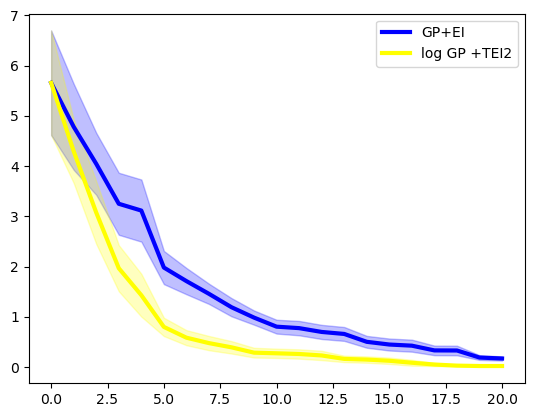

In [15]:
N = 20

total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')



# total_record = np.array(BO_MES)-fstar
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,label='GP+MES',color='#c22f2f')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.array(Warped_BO_TEI2)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI2',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

# total_record = np.array(BO_ERM)-fstar
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,label='ERM',color='black')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

# total_record = np.array(BO_LCB)-fstar
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,label='LCB',color='green')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

plt.legend()

# Check distance from the so-far best

In [18]:
BO_EI = []
distance_holder = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    best_record = [Y_BO.min().item()]
    distance_record = []

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            minimal = train_Y.min().item()
        
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            best_x = train_X[np.argmin(train_Y)]
            
            # train the GP
            res = optimise(train_X,train_Y)
            # print('lengthscale is: ',np.sqrt(res[0])) 
            # print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            
            distance = np.linalg.norm(standard_next_X-best_x)
            distance_record.append(distance)
            
            
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record)
            
    best_record = np.array(best_record)+fstar 
    BO_EI.append(best_record)
    distance_holder.append(distance_record)

0
1
2
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
3
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
4
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
5
6
7
8
9
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
10
issue

In [26]:
np.savetxt('training_check/Powell4D_BO_EI', BO_EI, delimiter=',')

In [19]:
np.savetxt('training_check/Ackley7D_BO_EI_distance', distance_holder, delimiter=',')